# Gesture Recognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import abc
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K
import cv2

In [3]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
project_folder='/home/datasets/Project_data'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# Defining a BuildModel Class which will have all commmon operations which need to performed while trying different models 
# This class will be used to 
#   - Initialize Input Path
#   - Set Image Properties
#   - Set hyperpameters like no. of frames, batch size, no. of epochs 
#   - Generator Function
#   - Train Model

class BuildModel(metaclass= abc.ABCMeta):
    # Define the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    # Set the image properties    
    def set_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    # Set the batch size, frames to sample and the no. of epochs
    def set_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    #The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq ='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Sample Model

In [6]:
#Lets Build a Sample Model Using BuildModel Class
class SampleModel(BuildModel):
    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Conv3D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling3D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [7]:
sm=SampleModel()
sm.initialize_path(project_folder)
sm.set_image_properties(image_height=160,image_width=160)
sm.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
sample_model=sm.define_model()
sample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 158, 158, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 79, 79, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 77, 77, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 38, 38, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 554496)            0         
                                                                 
 dense (Dense)               (None, 256)               1

2024-07-30 18:32:35.619526: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-30 18:32:35.619593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.


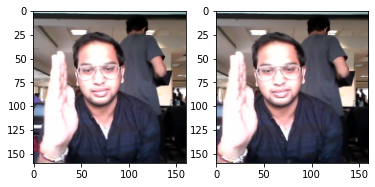

In [8]:
test_generator=SampleModel()
test_generator.initialize_path(project_folder)
test_generator.set_image_properties(image_height=160,image_width=160)
test_generator.set_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

<B> Image resolution, number of images & Batch size are key parameters which are going to affect traninnig time.
<B>Lets experiment around these params

In [9]:
#Build a Sample Model 1 with Image Resolution = 100*100, NO. Of Frames = 15 & Batch Size = 30
sm1=SampleModel()
sm1.initialize_path(project_folder)
sm1.set_image_properties(image_height=100,image_width=100)
sm1.set_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
sample_model1=sm1.define_model()
print("Total Params:", sample_model1.count_params())
sm1.train_model(sample_model1)

Total Params: 17393797
Epoch 1/2


2024-07-30 18:32:42.370362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 40.7759 - categorical_accuracy: 0.1976
Epoch 00001: val_loss improved from inf to 1.61518, saving model to model_init_2024-07-3018_32_37.958423/model-00001-40.77587-0.19759-1.61518-0.18000.h5
23/23 [==============================] - 81s 4s/step - loss: 40.7759 - categorical_accuracy: 0.1976 - val_loss: 1.6152 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.6118 - categorical_accuracy: 0.2051
Epoch 00002: val_loss improved from 1.61518 to 1.61027, saving model to model_init_2024-07-3018_32_37.958423/model-00002-1.61183-0.20513-1.61027-0.17000.h5
23/23 [==============================] - 80s 4s/step - loss: 1.6118 - categorical_accuracy: 0.2051 - val_loss: 1.6103 - val_categorical_accuracy: 0.1700 - lr: 0.0100


In [10]:
#Build a Sample Model2 with Image Resolution = 120*120, NO. Of Frames = 15 & Batch Size = 15
sm2=SampleModel()
sm2.initialize_path(project_folder)
sm2.set_image_properties(image_height=120,image_width=120)
sm2.set_hyperparams(frames_to_sample=15,batch_size=15,num_epochs=2)
sample_model2=sm2.define_model()
print("Total Params:", sample_model2.count_params())
sm2.train_model(sample_model2)

Total Params: 25749637
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 23.5156 - categorical_accuracy: 0.1825
Epoch 00001: val_loss improved from inf to 1.60814, saving model to model_init_2024-07-3018_35_22.130852/model-00001-23.51557-0.18250-1.60814-0.23000.h5
45/45 [==============================] - 81s 2s/step - loss: 23.5156 - categorical_accuracy: 0.1825 - val_loss: 1.6081 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.1840
Epoch 00002: val_loss improved from 1.60814 to 1.60794, saving model to model_init_2024-07-3018_35_22.130852/model-00002-1.61075-0.18401-1.60794-0.21000.h5
45/45 [==============================] - 82s 2s/step - loss: 1.6107 - categorical_accuracy: 0.1840 - val_loss: 1.6079 - val_categorical_accuracy: 0.2100 - lr: 0.0100


# We have got out of memory error with Image Resolution 160X160 and Number of Frames = 30 

2024-07-29 12:08:01.903355: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB (rounded to 2684129280)requested by op sequential_14/max_pooling3d_28/MaxPool3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-29 12:08:01.903424: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc

In [11]:
#Build a Sample Model 3 with Image Resolution = 160*160, NO. Of Frames = 30 & Batch Size = 15

#sm3=SampleModel()
#sm3.initialize_path(project_folder)
#sm3.set_image_properties(image_height=160,image_width=160)
#sm3.set_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
#sample_model3=sm3.define_model()
#print("Total Params:", sample_model3.count_params())
#sm3.train_model(sample_model3)

# Conclusion
1. So from the above experiments "image resolution" and number of frames in sequence have more impact on training time
2. Batch Size around 15-40 would be ideal
3. The resoulution can be 160X160, 128X128, 120X120 depending upon the model performance

# Model 1
## Conv3D Model - Batch Size = 40 and No. of Epochs = 15

In [12]:
class Model1(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
mod1conv3d=Model1()
mod1conv3d.initialize_path(project_folder)
mod1conv3d.set_image_properties(image_height=160,image_width=160)
mod1conv3d.set_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
model1=mod1conv3d.define_model()
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)   

In [14]:
print("Total Params:", model1.count_params())
model1_history = mod1conv3d.train_model(model1)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5326 - categorical_accuracy: 0.4223
Epoch 00001: val_loss improved from inf to 1.67941, saving model to model_init_2024-07-3018_38_06.886143/model-00001-1.53260-0.42232-1.67941-0.24000.h5
17/17 [==============================] - 126s 8s/step - loss: 1.5326 - categorical_accuracy: 0.4223 - val_loss: 1.6794 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1016 - categorical_accuracy: 0.5656
Epoch 00002: val_loss did not improve from 1.67941
17/17 [==============================] - 120s 7s/step - loss: 1.1016 - categorical_accuracy: 0.5656 - val_loss: 1.7264 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8594 - categorical_accuracy: 0.6727
Epoch 00003: val_loss did not improve from 1.67941
17/17 [==============================] - 118s 7s/step - loss: 0.8594 - c

In [15]:
# Function to plot the training vs validation accuracies/losses.

def plot(model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(model.history['loss'])   
    axes[0].plot(model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(model.history['categorical_accuracy'])   
    axes[1].plot(model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

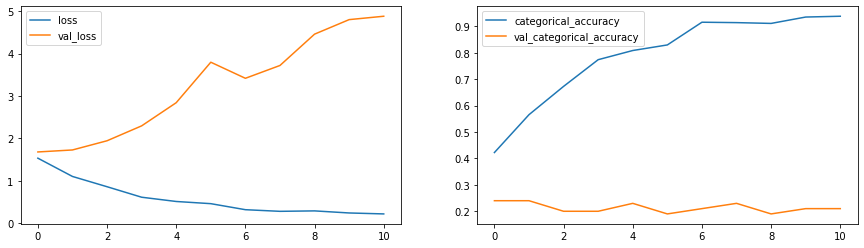

In [16]:
plot(model1_history)

##### The Last stop at 11/25 since there no improvement in the validation Loss
##### Also we can see there is huge difference in both 
#####   - Training Loss and Valudation Loss
#####   - Though Traning Accuracy is 93%; Validation Accuracy is 21% 
#### This means the model is overfitting and not suitable

# Model 2
## Conv3D Model - Batch Size = 20, No. of Epochs = 15 & Adding dropout layers

In [17]:
mod2conv3d=Model1()
mod2conv3d.initialize_path(project_folder)
mod2conv3d.set_image_properties(image_height=160,image_width=160)
mod2conv3d.set_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
model2=mod2conv3d.define_model(dense_neurons=256,dropout=0.5)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [18]:
print("Total Params:", model2.count_params())
model2_history=mod2conv3d.train_model(model2,augment_data=True)

Total Params: 3638981
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8035 - categorical_accuracy: 0.4065
Epoch 00001: val_loss improved from inf to 2.76660, saving model to model_init_2024-07-3019_00_09.134020/model-00001-1.80346-0.40649-2.76660-0.21000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.8035 - categorical_accuracy: 0.4065 - val_loss: 2.7666 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3908 - categorical_accuracy: 0.5234
Epoch 00002: val_loss did not improve from 2.76660
34/34 [==============================] - 218s 7s/step - loss: 1.3908 - categorical_accuracy: 0.5234 - val_loss: 5.1029 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1849 - categorical_accuracy: 0.5958
Epoch 00003: val_loss did not improve from 2.76660
34/34 [==============================] - 223s 7s/step - loss: 1.1849 - c

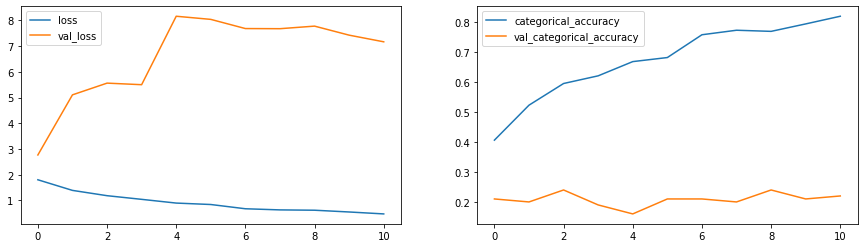

In [19]:
plot(model2_history)

#### So in this model as well we see val_loss did not improve from 2.76660 so earlystopping stops the epoch automatically!!
#### Last Epoch stop on 11/15.
#### Also we can see there is huge difference in both
####   - Training Loss and Valudation Loss
####   - Though Traning Accuracy is 82%; Validation Accuracy is 22%
#### This model is overfitting and not suitable

### Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.02

# Model 3
## Cone3D - Batch Size = 30, No. of Epochs = 25, Reduce filter size to (2,2,2) & Image Resolution to 120X120

In [20]:
class Model3(BuildModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.02)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
mod3conv3d=Model3()
mod3conv3d.initialize_path(project_folder)
mod3conv3d.set_image_properties(image_height=120,image_width=120)
mod3conv3d.set_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
model3=mod3conv3d.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [22]:
print("Total Params:", model3.count_params())
Model3_history=mod3conv3d.train_model(model3,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1465 - categorical_accuracy: 0.3808
Epoch 00001: val_loss improved from inf to 904.00818, saving model to model_init_2024-07-3019_40_14.945965/model-00001-2.14650-0.38084-904.00818-0.23000.h5
23/23 [==============================] - 156s 7s/step - loss: 2.1465 - categorical_accuracy: 0.3808 - val_loss: 904.0082 - val_categorical_accuracy: 0.2300 - lr: 0.0200
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4724 - categorical_accuracy: 0.4570
Epoch 00002: val_loss improved from 904.00818 to 308.58679, saving model to model_init_2024-07-3019_40_14.945965/model-00002-1.47238-0.45701-308.58679-0.24000.h5
23/23 [==============================] - 153s 7s/step - loss: 1.4724 - categorical_accuracy: 0.4570 - val_loss: 308.5868 - val_categorical_accuracy: 0.2400 - lr: 0.0200
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2830 - categorical_accuracy: 0.4872
Epoc

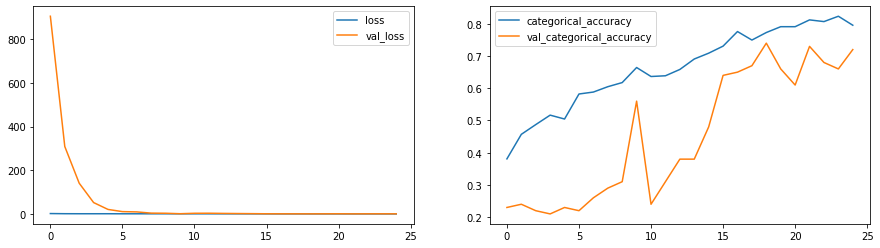

In [23]:
plot(Model3_history)

#### Reducing number of layers has helped us to get good results
#### Now Validation Loss is 0.8 and also we can see
####    - Training Accuracy = 79% and Validation Accuracy as 72%

### Model 4
#### Conv3d - Reducing number of layers

In [24]:
class Model4(BuildModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
mod4conv3d=Model4()
mod4conv3d.initialize_path(project_folder)
mod4conv3d.set_image_properties(image_height=120,image_width=120)
mod4conv3d.set_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
model4=mod4conv3d.define_model(dense_neurons=64,dropout=0.25)
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

In [26]:
print("Total Params:", model4.count_params())
Model4_history=mod4conv3d.train_model(model4,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5626 - categorical_accuracy: 0.3869
Epoch 00001: val_loss improved from inf to 156.42059, saving model to model_init_2024-07-3020_44_12.841151/model-00001-1.56262-0.38688-156.42059-0.23000.h5
34/34 [==============================] - 155s 5s/step - loss: 1.5626 - categorical_accuracy: 0.3869 - val_loss: 156.4206 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1645 - categorical_accuracy: 0.4955
Epoch 00002: val_loss improved from 156.42059 to 33.70905, saving model to model_init_2024-07-3020_44_12.841151/model-00002-1.16452-0.49548-33.70905-0.24000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.1645 - categorical_accuracy: 0.4955 - val_loss: 33.7090 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0068 - categorical_accuracy: 0.5656
Epoch 00

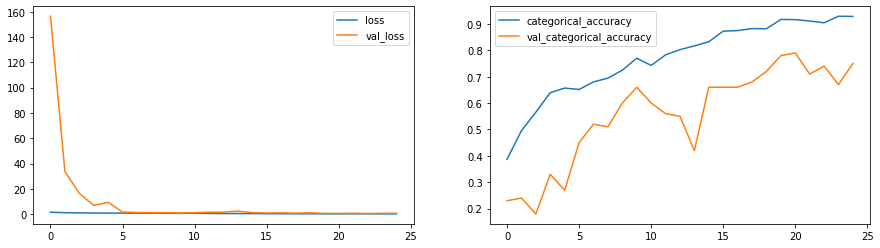

In [27]:
plot(Model4_history)

#### Reducing further layers has helped us get more improvement in the model 
#### Now we have Validation Loss further reduced to 0.7048
#### We have Traning Accuracy = 92% and Validation Accuracy = 75% 
#### Still there is a gap beetween these two. Lets try reducing dropout

#### Model 5
##### Reducing number of layers, Image Resolution 128X128, No. Of Frames to 16 and Batch Size = 15
##### Applying dropout = 0.2

In [28]:
class Model5(BuildModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):
        
        model = Sequential()

        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Conv3D(256, (1, 3, 3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
mod5conv3d=Model5()
mod5conv3d.initialize_path(project_folder)
mod5conv3d.set_image_properties(image_height=128,image_width=128)
mod5conv3d.set_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=25)
model5=mod5conv3d.define_model(dense_neurons=64,dropout=0.2)
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 16, 128, 128, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 128, 128, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 128, 128, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 8, 64, 64, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 6, 62, 62, 128)    55424     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 6, 31, 31, 128)  

In [30]:
print("Total Params:", model5.count_params())
Model5_history=mod5conv3d.train_model(model5,augment_data=True)

Total Params: 39027365
Epoch 1/25
45/45 [==============================] - 166s 4s/step - loss: 1.6596 - categorical_accuracy: 0.3386 - val_loss: 102.5632 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.2288 - categorical_accuracy: 0.4721
Epoch 00002: val_loss improved from 102.56319 to 73.59152, saving model to model_init_2024-07-3021_49_26.047793/model-00002-1.22882-0.47210-73.59152-0.23000.h5
45/45 [==============================] - 162s 4s/step - loss: 1.2288 - categorical_accuracy: 0.4721 - val_loss: 73.5915 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.0746 - categorical_accuracy: 0.5430
Epoch 00003: val_loss improved from 73.59152 to 9.62200, saving model to model_init_2024-07-3021_49_26.047793/model-00003-1.07458-0.54299-9.62200-0.24000.h5
45/45 [==============================] - 165s 4s/step - loss: 1.0746 - categorical_accuracy: 0.5430 

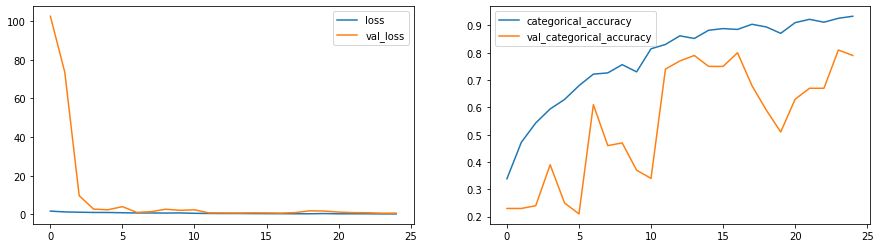

In [31]:
plot(Model5_history)

##### With this mode we can have achieved validation accuracy of 74% 

### Model 6
#### CNN + LSTM Model

In [32]:
class RNNCNN1(BuildModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
rnncnnmod1=RNNCNN1()
rnncnnmod1.initialize_path(project_folder)
rnncnnmod1.set_image_properties(image_height=120,image_width=120)
rnncnnmod1.set_hyperparams(frames_to_sample=18,batch_size=15,num_epochs=40)
rnncnn_model1=rnncnnmod1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.2)
rnncnn_model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 18, 60, 60, 32) 

In [37]:
print("Total Params:", rnncnn_model1.count_params())
Model6_history=rnncnnmod1.train_model(rnncnn_model1,augment_data=True)

Total Params: 1922149
Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 1.5615 - categorical_accuracy: 0.2964
Epoch 00001: val_loss improved from inf to 2.21735, saving model to model_init_2024-07-3100_10_51.540660/model-00001-1.56153-0.29638-2.21735-0.23000.h5
45/45 [==============================] - 181s 4s/step - loss: 1.5615 - categorical_accuracy: 0.2964 - val_loss: 2.2173 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
45/45 [==============================] - ETA: 0s - loss: 1.3091 - categorical_accuracy: 0.3846
Epoch 00002: val_loss did not improve from 2.21735
45/45 [==============================] - 174s 4s/step - loss: 1.3091 - categorical_accuracy: 0.3846 - val_loss: 3.2986 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/40
45/45 [==============================] - ETA: 0s - loss: 1.4290 - categorical_accuracy: 0.3582
Epoch 00003: val_loss improved from 2.21735 to 2.16694, saving model to model_init_2024-07-3100_10_51.540660/model-00003-1.

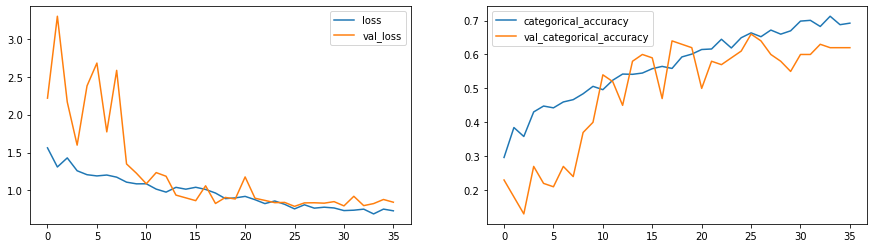

In [42]:
plot(Model6_history)

##### Though there is no improvement in Val Loss after 0.78924 at Epoch 26 we can see both training and validation accuracy is 66%

#### Model 7

In [39]:
rnncnnmod2=RNNCNN1()
rnncnnmod2.initialize_path(project_folder)
rnncnnmod2.set_image_properties(image_height=120,image_width=120)
rnncnnmod2.set_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=40)
rnncnn_model2=rnncnnmod2.define_model(lstm_cells=64,dense_neurons=64,dropout=0.2)
rnncnn_model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_57 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 16, 60, 60, 32) 

In [40]:
print("Total Params:", rnncnn_model2.count_params())
Model7_history=rnncnnmod2.train_model(rnncnn_model2,augment_data=True)

Total Params: 1728997
Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 1.6064 - categorical_accuracy: 0.2715
Epoch 00001: val_loss improved from inf to 1.73612, saving model to model_init_2024-07-3101_55_44.490455/model-00001-1.60636-0.27149-1.73612-0.23000.h5
45/45 [==============================] - 174s 4s/step - loss: 1.6064 - categorical_accuracy: 0.2715 - val_loss: 1.7361 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
45/45 [==============================] - ETA: 0s - loss: 1.4020 - categorical_accuracy: 0.3514
Epoch 00002: val_loss did not improve from 1.73612
45/45 [==============================] - 167s 4s/step - loss: 1.4020 - categorical_accuracy: 0.3514 - val_loss: 2.7035 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/40
45/45 [==============================] - ETA: 0s - loss: 1.3024 - categorical_accuracy: 0.3989
Epoch 00003: val_loss did not improve from 1.73612
45/45 [==============================] - 158s 4s/step - loss: 1.3024 - c

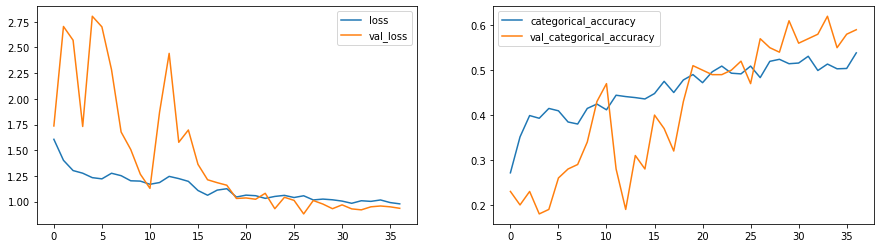

In [43]:
plot(Model7_history)

##### With Image Resolution 120X120 we are unable to significant improvement in the Accuracy. 

#### Model 8 
##### Lets try Increasing Epochs to 40, Reducing No. of Frames to 10

In [44]:
rnncnnmod3=RNNCNN1()
rnncnnmod3.initialize_path(project_folder)
rnncnnmod3.set_image_properties(image_height=120,image_width=120)
rnncnnmod3.set_hyperparams(frames_to_sample=10,batch_size=15,num_epochs=40)
rnncnn_model3=rnncnnmod3.define_model(lstm_cells=64,dense_neurons=64,dropout=0.2)
rnncnn_model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_76 (TimeDi  (None, 10, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_77 (TimeDi  (None, 10, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 10, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 10, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 10, 60, 60, 32) 

In [45]:
print("Total Params:", rnncnn_model3.count_params())
Model8_history=rnncnnmod3.train_model(rnncnn_model3,augment_data=True)

Total Params: 1728997
Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 1.5673 - categorical_accuracy: 0.2866
Epoch 00001: val_loss improved from inf to 1.87844, saving model to model_init_2024-07-3103_39_41.142710/model-00001-1.56727-0.28658-1.87844-0.23000.h5
45/45 [==============================] - 116s 3s/step - loss: 1.5673 - categorical_accuracy: 0.2866 - val_loss: 1.8784 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
45/45 [==============================] - ETA: 0s - loss: 1.4624 - categorical_accuracy: 0.3205
Epoch 00002: val_loss improved from 1.87844 to 1.58935, saving model to model_init_2024-07-3103_39_41.142710/model-00002-1.46243-0.32051-1.58935-0.31000.h5
45/45 [==============================] - 111s 3s/step - loss: 1.4624 - categorical_accuracy: 0.3205 - val_loss: 1.5894 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/40
45/45 [==============================] - ETA: 0s - loss: 1.4157 - categorical_accuracy: 0.3582
Epoch 00003: val_l

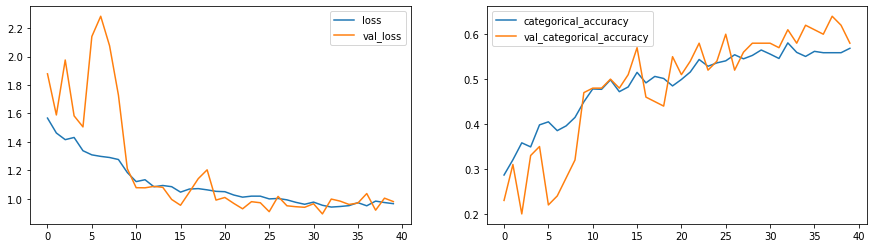

In [46]:
plot(Model8_history)

#### Though model is not overfitting the accuracy for the model is around ~50%
#### Lets try selecting alternate frames from 5-26 since after analysing first 5 and last 5 frames doesnt have much siginifacnt gessture information
#### Also increasing learning rate to 0.002

In [54]:
# Defining a BuildModel2 Class which will have all commmon operations which need to performed while trying different models 
# Selecting Alternate fromaes from 5 to 26 

class BuildModel2(metaclass= abc.ABCMeta):
    # Define the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    # Set the image properties    
    def set_image_properties(self,image_height=100,image_width=100): 
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    # Set the batch size, the no. of epochs
    # Selecting alternate frames from 5 to 26.
    def set_hyperparams(self,batch_size=20,num_epochs=20):
        self.seq_index  = range (5,26,2)
        self.frames_to_sample=len(self.seq_index)
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    #The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = self.seq_index
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq ='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

#### Model 9

In [55]:
class RNNCNN2(BuildModel2):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.02)
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [56]:
rnncnnmod4=RNNCNN2()
rnncnnmod4.initialize_path(project_folder)
rnncnnmod4.set_image_properties(image_height=120,image_width=120)
rnncnnmod4.set_hyperparams(batch_size=15,num_epochs=50)
rnncnn_model4=rnncnnmod4.define_model(lstm_cells=64,dense_neurons=64,dropout=0.2)
rnncnn_model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_111 (TimeD  (None, 11, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_112 (TimeD  (None, 11, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, 11, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 11, 60, 60, 64)   9280      
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, 11, 60, 60, 64) 

In [57]:
print("Total Params:", rnncnn_model4.count_params())
Model9_history=rnncnnmod4.train_model(rnncnn_model4,augment_data=True)

Total Params: 2763589
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.2692
Epoch 00001: val_loss improved from inf to 1.66627, saving model to model_init_2024-07-3104_58_06.324307/model-00001-1.60867-0.26923-1.66627-0.23000.h5
45/45 [==============================] - 128s 3s/step - loss: 1.6087 - categorical_accuracy: 0.2692 - val_loss: 1.6663 - val_categorical_accuracy: 0.2300 - lr: 0.0200
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 1.5309 - categorical_accuracy: 0.3024
Epoch 00002: val_loss did not improve from 1.66627
45/45 [==============================] - 123s 3s/step - loss: 1.5309 - categorical_accuracy: 0.3024 - val_loss: 1.9963 - val_categorical_accuracy: 0.1700 - lr: 0.0200
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.4093 - categorical_accuracy: 0.3288
Epoch 00003: val_loss did not improve from 1.66627
45/45 [==============================] - 117s 3s/step - loss: 1.4093 - c

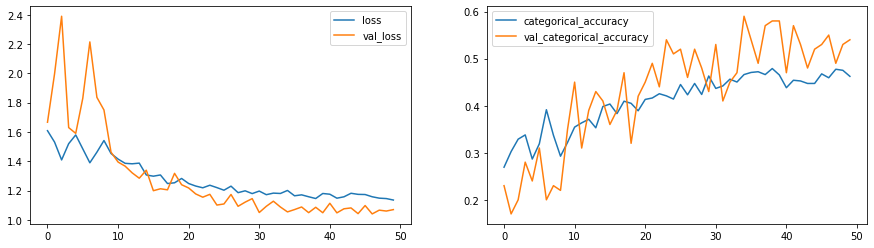

In [62]:
plot(Model9_history)

#### Not much improvement in the model with this approach as well.
#### Lets try reducing layers and increasing learning rate to 0.02

### Model 10

In [63]:
class RNNCNN3(BuildModel2):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.02)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [64]:
rnncnnmod5=RNNCNN3()
rnncnnmod5.initialize_path(project_folder)
rnncnnmod5.set_image_properties(image_height=120,image_width=120)
rnncnnmod5.set_hyperparams(batch_size=15,num_epochs=50)
rnncnn_model5=rnncnnmod5.define_model(lstm_cells=64,dense_neurons=64,dropout=0.2)
rnncnn_model5.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_143 (TimeD  (None, 11, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_144 (TimeD  (None, 11, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_145 (TimeD  (None, 11, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_146 (TimeD  (None, 11, 60, 60, 64)   9280      
 istributed)                                                     
                                                                 
 time_distributed_147 (TimeD  (None, 11, 60, 60, 64) 

In [ ]:
print("Total Params:", rnncnn_model5.count_params())
Model10_history=rnncnnmod5.train_model(rnncnn_model5,augment_data=True)

Total Params: 7784645
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.5787 - categorical_accuracy: 0.2843
Epoch 00001: val_loss improved from inf to 1.91557, saving model to model_init_2024-07-3106_27_47.999090/model-00001-1.57873-0.28431-1.91557-0.23000.h5
45/45 [==============================] - 109s 2s/step - loss: 1.5787 - categorical_accuracy: 0.2843 - val_loss: 1.9156 - val_categorical_accuracy: 0.2300 - lr: 0.0200
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 1.5821 - categorical_accuracy: 0.2647
Epoch 00002: val_loss improved from 1.91557 to 1.75180, saving model to model_init_2024-07-3106_27_47.999090/model-00002-1.58207-0.26471-1.75180-0.26000.h5
45/45 [==============================] - 106s 2s/step - loss: 1.5821 - categorical_accuracy: 0.2647 - val_loss: 1.7518 - val_categorical_accuracy: 0.2600 - lr: 0.0200
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.5159 - categorical_accuracy: 0.3115
Epoch 00003: val_l

In [ ]:
plot(Model10_history)